In [ ]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
from ROOT import gROOT,gStyle,gPad
from ROOT import std
import csv
import json
import array as array
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

import numpy as np


import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
reload(CB)
import CrystalMap as crystMap
reload(crystMap)
from uncertainties import unumpy
from uncertainties import ufloat

In [ ]:
dir_str = '/02_08_2019/'
plot_folder = 'plots/'+dir_str
output_folder = 'output/'+dir_str
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
dict_C3_energy_scan = {}
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if crystal=='C3' :
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        

            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
dict_crystal_centers['C3_3x3'] =[4,5]       
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')            

In [ ]:
outstr = 'time_v7'
#trees_path = '/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/'
trees_path = '/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7/'

In [ ]:
reload(crystMap)

canvas_num=0
c = ROOT.TCanvas("c","c",500,500)
crystal='C3'
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energy  = str(energies[-1])
runs = dict_C3_energy_scan[energy]
tree = ROOT.TChain("h4")
for run in runs:
    tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))
selection = 'fit_ampl[MCP1]>100 && fit_ampl[%s]>1000 && n_tracks==1 && fabs(X-(%.2f))<4 && fabs(Y-(%.2f))<4'%(crystal,dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1])
hist = ROOT.TH1F('h','h',100,2000,3000)
tree.Draw("((fit_time[%s]-fit_time[MCP1]+fit_time[VFE_CLK])-int((fit_time[%s]-fit_time[MCP1]+fit_time[VFE_CLK])/6.238)*6.238)*1000>>h"%(crystal,crystal),selection)
hist.Draw("HIST")
c.Draw()

# Prepare time data for the minimization

In [ ]:
import pandas as pd

crystal='C3'
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energy  = str(energies[-1])
print energy
runs = dict_C3_energy_scan[energy]
tree = ROOT.TChain("h4")
for run in runs:
    tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))
#selection = 'fit_ampl[MCP1]>100 && fit_ampl[MCP2]>100 && fit_ampl[%s]>1000 && n_tracks==1 && fabs(X-(%.2f))<4 && fabs(Y-(%.2f))<4'%(crystal,dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1])
pos_cut = 4
data = []
for evt in tree:
    if evt.fit_ampl[getattr(evt, crystal)]>1000 and evt.fit_ampl[evt.MCP1]>100 and evt.fit_ampl[evt.MCP2]>100 and evt.n_tracks==1 and abs(evt.X[0]-dict_crystal_centers[crystal][0])<pos_cut and abs(evt.Y[0]-dict_crystal_centers[crystal][1])<pos_cut : 
        evt_dict = {}
        evt_dict['Energy'] = evt.Energy
        evt_dict['fit_ampl_MCP1'] = evt.fit_ampl[evt.MCP1]
        evt_dict['fit_ampl_MCP2'] = evt.fit_ampl[evt.MCP2]
        evt_dict['fit_time_MCP1'] = evt.fit_time[evt.MCP1]
        evt_dict['fit_time_MCP2'] = evt.fit_time[evt.MCP2]
        for xstal in ['C3']:
            evt_dict['fit_ampl_'+xstal] = evt.fit_ampl[getattr(evt, xstal)]
            evt_dict['noise_'+xstal] = evt.b_rms[getattr(evt, xstal)]
            evt_dict['fit_time_'+xstal] = evt.fit_time[getattr(evt, xstal)]
            evt_dict['dt_ecal_mcp1_'+xstal] = ((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
            evt_dict['dt_ecal_mcp2_'+xstal] = ((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP2]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP2]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
            evt_dict['dt_mcp2_mcp1_'+xstal] = (evt.fit_time[evt.MCP2]-evt.fit_time[evt.MCP1])*1000.
        data.append(evt_dict)

df = pd.DataFrame(data)    


In [6]:
print df.shape

(65535, 11)


In [ ]:
gROOT.LoadMacro('utils/LLminimizer/LLminimizer.cc')


In [ ]:
#from array import array
#time_minimizer = ROOT.LLminimizer(array('d',list(df['fit_ampl_MCP1'])),array('d',list(df['fit_ampl_MCP2'])), 
 #                          array('d',list(df['dt_ecal_mcp1_C3'])),array('d',list(df['dt_ecal_mcp2_C3'])),
  #                         array('d',list(df['dt_mcp2_mcp1_C3'])),crystal,energy)


In [ ]:
#inputs = [std.vector('double')(10),std.vector('double')(10),std.vector('double')(10),std.vector('double')(10),std.vector('double')(10)]
#inputs_names = ['fit_ampl_MCP1','fit_ampl_MCP2','dt_ecal_mcp1_C3','dt_ecal_mcp2_C3','dt_mcp2_mcp1_C3']
#for num,name in enumerate(inputs_names):
#    for i in range(0,10):
#        inputs[num][i] = list(df[name])[i]


In [ ]:
#time_minimizer = ROOT.LLminimizer(inputs[0],inputs[1],inputs[2],inputs[3],inputs[4],crystal,energy)
from array import array
time_minimizer = ROOT.LLminimizer(df['fit_ampl_MCP1'].shape[0],array('d',list(df['fit_ampl_MCP1'])),array('d',list(df['fit_ampl_MCP2'])),array('d',list(df['dt_ecal_mcp1_C3'])),array('d',list(df['dt_ecal_mcp2_C3'])),array('d',list(df['dt_mcp2_mcp1_C3'])),crystal,energy)


In [12]:
#from ROOT import std
#b = std.vector('double')(10)
#time_minimizer = ROOT.LLminimizer(b,b,b,b,b,crystal,energy)

#v = std.vector(ROOT.Double)()
#v += [5,6,7,8]

In [ ]:
time_minimizer.MinimizeNLL()

In [10]:
print  time_minimizer.m_Cm_
print time_minimizer.m_a1_
#time_minimizer.m_Cm_e_

5.0
20.0


In [27]:
for input in inputs:
    print input

{ 1886.4337, 778.20728, 504.99210, 1171.0276, 814.35138, 1022.1780, 274.83176, 662.47040, 1103.1155, 294.32684 }
{ 1886.4337, 778.20728, 504.99210, 1171.0276, 814.35138, 1022.1780, 274.83176, 662.47040, 1103.1155, 294.32684 }
{ 1886.4337, 778.20728, 504.99210, 1171.0276, 814.35138, 1022.1780, 274.83176, 662.47040, 1103.1155, 294.32684 }
{ 1886.4337, 778.20728, 504.99210, 1171.0276, 814.35138, 1022.1780, 274.83176, 662.47040, 1103.1155, 294.32684 }
{ 1886.4337, 778.20728, 504.99210, 1171.0276, 814.35138, 1022.1780, 274.83176, 662.47040, 1103.1155, 294.32684 }


In [20]:
len(df['fit_ampl_MCP1'])

1322

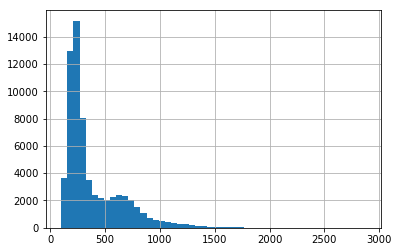

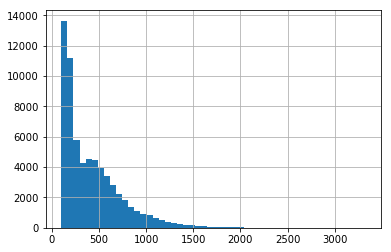

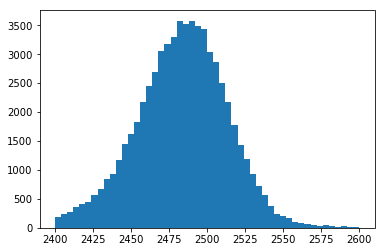

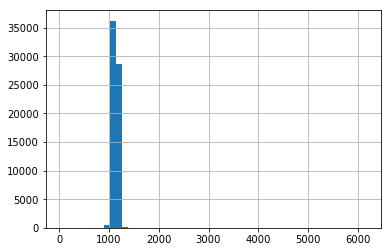

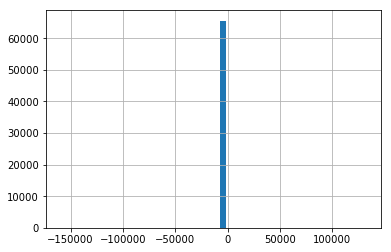

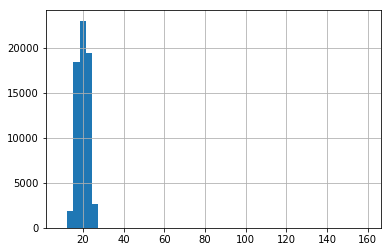

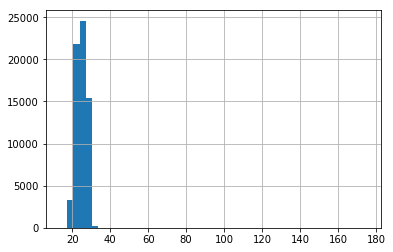

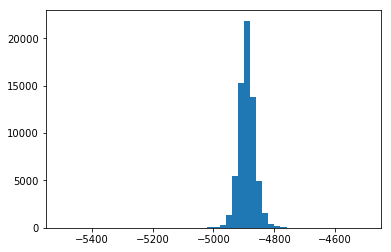

In [9]:
df['fit_ampl_MCP1'].hist(bins=50)
plt.show()
df['fit_ampl_MCP2'].hist(bins=50)
plt.show()
plt.hist(list(df['dt_ecal_mcp1_C3']),bins=50,range=[2400,2600])
plt.show()
df['dt_ecal_mcp2_C3'].hist(bins=50)
plt.show()
df['dt_mcp2_mcp1_C3'].hist(bins=50)
plt.show()
df['fit_time_MCP2'].hist(bins=50)
plt.show()
df['fit_time_MCP1'].hist(bins=50)
plt.show()
plt.hist(list(df['dt_mcp2_mcp1_C3']),bins=50,range=[-5500,-4500])
plt.show()



In [30]:
df[df['fit_time_MCP1'].gt(40)].index[0]

6517

In [35]:
df.shape

(22122, 11)

In [40]:
df['dt_mcp2_mcp1_C3'][4]

-4869.5831298828125